# Processing the B3DB brain-blood barrier dataset
> 

- toc: true 
- badges: true
- comments: true
- categories: [python, bioinformatics, datasets, SMILES, cheminformatics, datamol, RDKit, molecules]
- image: images/bloodcell.gif

# Gathering data on blood brain barrier permeability

This post is a part of a fullstack machine learning web app project and this notebook contains the data needed to build and train the models. The goal in this post is to clean and preprocess the B3DB dataset and merge it with the blood brain permeability data from MoleculeNet. The merged dataset should contain nearly 10,000 molecules labeled with their ability to pass through the blood brain barrier. The notebook provided in the B3DB repository also contains an interesting PCA plot, which is a good starting place for exploratory data analysis (EDA) when the data is merged.

In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA


%matplotlib inline

In [80]:
bbb_df = pd.read_csv("data/B3DB_classification.tsv", 
                                       sep="\t")

In [81]:
bbb_df = bbb_df.drop(["CID", "logBB", "Inchi", "threshold", "reference", "group", "comments", "NO.", "IUPAC_name", "compound_name"], axis=1)

In [82]:
bbb_df['BBB+/BBB-'] = bbb_df['BBB+/BBB-'].map({'BBB+': 1, 'BBB-': 0})

In [83]:
bbb_df

,SMILES,BBB+/BBB-
0,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,0
1,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,0
2,Oc1c(I)cc(Cl)c2cccnc12,0
3,CCNC(=NCCSCc1ncccc1Br)NC#N,0
4,CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,0
...,...,...
7802,c1ccc(CN(CC2=NCCN2)c2ccccc2)cc1,0
7803,CCOCCn1c(N2CCCN(C)CC2)nc2ccccc21,1
7804,CN1CCC(=C2c3ccccc3CC(=O)c3sccc32)CC1,1
7805,Cc1[nH]c(=O)c(C#N)cc1-c1ccncc1,0


In [84]:
# compute ECFP6 fingerprints
fps = []

for idx, row in bbb_df.iterrows():
    mol = Chem.MolFromSmiles(row["SMILES"])
    mol = Chem.AddHs(mol)
    
    fp = AllChem.GetMorganFingerprintAsBitVect(mol=mol, 
                                               radius=3, 
                                               nBits=2048,
                                               useChirality=True, 
                                               useFeatures=False)
    fps.append(fp.ToBitString())

In [85]:
# uint8	u1	8-bit unsigned integer
fps_arr = np.array([np.fromiter(fp, "u1") for fp in fps])

In [86]:
fps_arr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [87]:
print("fingerprint array shape: ", fps_arr.shape)

fingerprint array shape:  (7807, 2048)


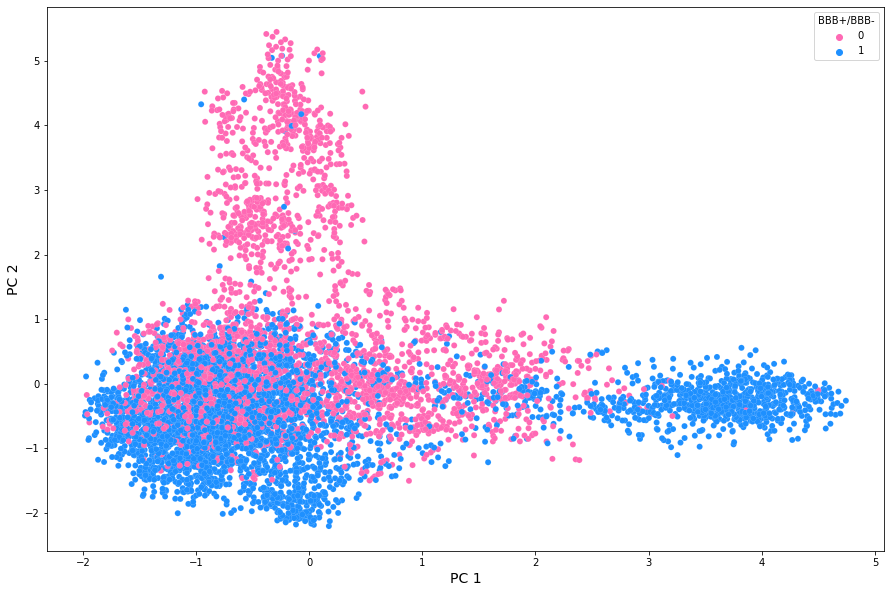

In [88]:


df_fps = pd.DataFrame(fps_arr, index=bbb_df.index)
df_new = pd.concat([bbb_df, df_fps], axis=1)

fig = plt.figure(figsize=(15, 10))

pca = PCA(n_components=2)
arr_fp_embedded = pca.fit_transform(fps_arr)
df_new["PC_1"] = arr_fp_embedded[:, 0]
df_new["PC_2"] = arr_fp_embedded[:, 1]

plt.xlabel("PC 1", fontsize=14)
plt.ylabel("PC 2", fontsize=14)

sns.scatterplot(data=df_new, x="PC_1", y="PC_2",
                hue="BBB+/BBB-",
                palette=sns.color_palette(["hotpink", "dodgerblue"]),
                linewidth=0.1,
                )
plt.show()